In [148]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers.highs import Highs

In [149]:
distance_matrix = pd.read_csv("Distance_matrix.csv").values
demands = pd.read_csv('demands.csv').values[0]

In [151]:
capacity = sum(demands) // 4

In [152]:
capacity

33

In [154]:
class Optimization:
    
    def __init__(self, capacity, demands, num_vehicles, distances):
        self.capacity = capacity
        self.demands = demands
        self.num_vehicles = num_vehicles
        self.distances = distances
        self.num_cities = len(distances)
        
    def model(self):
        self.model = pyo.ConcreteModel()
        self.model.N = pyo.RangeSet(1, self.num_cities)
        self.model.V = pyo.RangeSet(0, self.num_cities)
        self.model.K = pyo.RangeSet(1, self.num_vehicles)

        self.model.Q = self.capacity
        self.model.d = {i: self.demands[i-1] for i in self.model.N}
        self.model.c = {(i, j): self.distances[i-1][j-1] for i in self.model.V for j in self.model.V if i != j}

        self.model.x = pyo.Var(self.model.V, self.model.V, self.model.K, within=pyo.Binary)
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(0, self.model.Q))

        
        self.model.obj = pyo.Objective(expr=self.__obj_func, sense=pyo.minimize)

        self.model.cons1 = pyo.Constraint(self.model.N, rule=self.__rule_const1)
        self.model.cons2 = pyo.Constraint(self.model.K, rule=self.__rule_const2)
        self.model.cons3 = pyo.Constraint(self.model.K, rule=self.__rule_const3)
        self.model.cons4 = pyo.Constraint(self.model.N, self.model.N, self.model.K, rule=self.__rule_const4)

        
    @staticmethod
    def __obj_func(model):
        return sum(model.c[i, j] * model.x[i, j, k] for i in model.V for j in model.V for k in model.K if i != j)
    
    @staticmethod
    def __rule_const1(model, i):
        return sum(model.x[i, j, k] for j in model.V for k in model.K) == 1

    @staticmethod
    def __rule_const2(model, k):
        return sum(model.x[0, j, k] for j in model.N) == 1
    
    @staticmethod
    def __rule_const3(model, k):
        return sum(model.x[i, 0, k] for i in model.N) == 1

    @staticmethod
    def __rule_const4(model, i, j, k):
        return model.u[i] - model.u[j] + model.Q * model.x[i, j, k] <= model.Q - model.d[j]

        
    def print_model(self):
        self.model.pprint()
    
    def solve_model(self):
        solver = pyo.SolverFactory('cplex')
        result = solver.solve(self.model)
        print(result)
    
    def print_output(self):
        List = list(self.model.x.keys())
        valid_list = []
        for i in List:
            if self.model.x[i]() is not None and self.model.x[i]() != 0:
                valid_list.append(i)

        # Create a graph
        G = nx.Graph()

        edges = valid_list
        edges = [(i, j, {'vehicle': k}) for i, j, k in edges]
        # Add edges to the graph
        G.add_edges_from(edges)

        # Calculate the positions of the nodes using a spring layout
        pos = nx.spring_layout(G)

        # Define visualization options
        options = {
            "font_size": 5,
            "node_size": 100,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }

        # Draw the graph with options
        nx.draw_networkx(G, pos, **options)

        # Adjust margins before disabling axes
        ax = plt.gca()        
        ax.margins(0.20)

        # Turn off axes and show the plot
        plt.axis("off")
        plt.show()
        

In [155]:
opt = Optimization(capacity, demands, 3, distance_matrix)

In [156]:
opt.model()
# opt.print_model()
opt.solve_model()


Problem: 
- Name: tmp9f4swsyg
  Lower bound: 1428.0
  Upper bound: 1428.0
  Number of objectives: 1
  Number of constraints: 2736
  Number of variables: 2910
  Number of nonzeros: 10890
  Sense: minimize
Solver: 
- Status: ok
  User time: 1.16
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.4280000000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 31
      Number of created subproblems: 31
  Error rc: 0
  Time: 1.3578495979309082
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



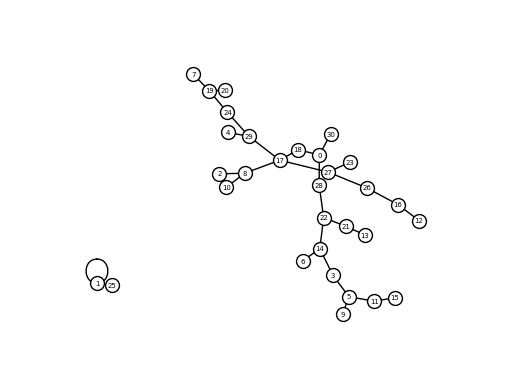

In [157]:
opt.print_output()